In [1]:
import numpy as np
import torch

from utils.helper_functions import load_dm
from utils.arguments import get_parser
from nets.wrapper import SegWrapper

import matplotlib.pyplot as plt

In [2]:
parser = get_parser()
args = parser.parse_args('''
--dataset HARTH --batch_size 64 --window_size 128 --normalize --subjects_for_test 21 20 19 18 17 
--n_val_subjects 4 --reduce_imbalance
--mode seg --overlap 0'''.split())

dm = load_dm(args)

Loaded dataset HARTH with a total of 6176235 observations for window size 128
Sampling 337026 (balanced) observations per epoch.
Using 4238949 observations for training, 9452 for validation and 7205 for test


In [3]:
cp = "_tests/seg_HARTH_21-20-19_2_128_1_bs64_lr0.001_l10_l20_utime12_mlpNone_1_ov0_2-2-2_1.5_ks3/version_0/checkpoints/epoch=3-step=26224-val_re=0.7623.ckpt"
model = SegWrapper.load_from_checkpoint(checkpoint_path=cp)
model.eval()
print()

In [4]:
model_outputs = []
labels = []
for id, data in enumerate(dm.test_dataloader()):
    model_outputs.append(model(data["series"].cuda(), None))
    labels.append(data["scs"])

model_outputs = torch.cat(model_outputs).cpu()
labels = torch.cat(labels).cpu()
model_outputs.shape

torch.Size([7205, 12, 128])

In [5]:
softmax_layer = torch.nn.Softmax(dim=1)

In [6]:
output_prob = softmax_layer(model_outputs)

In [11]:
output_prob.shape

torch.Size([7205, 12, 128])

In [7]:
max_prob = output_prob[torch.arange(output_prob.size(0)).unsqueeze(1), labels, torch.arange(output_prob.size(2))]

In [8]:
res = output_prob.max(1)[0]
crossentropy_value = torch.nn.functional.cross_entropy(model_outputs, labels, reduction="none", ignore_index=100)

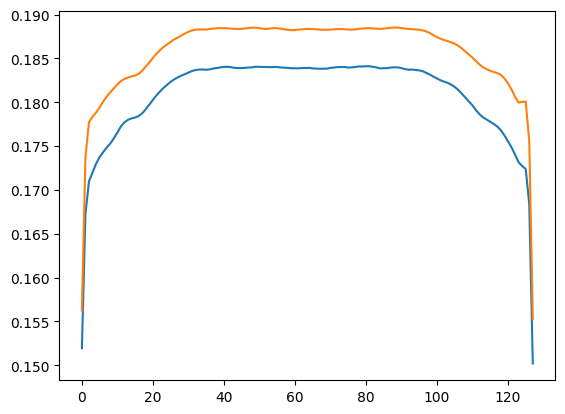

In [9]:
plt.plot(range(128), max_prob.mean(0).detach(), range(128), res.mean(0).detach())

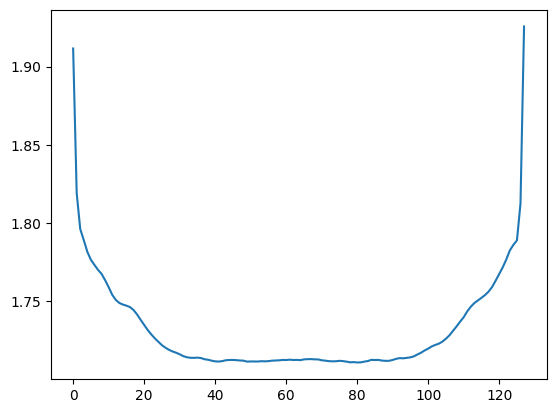

In [10]:
plt.plot(crossentropy_value.mean(0).detach())